In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from subprocess import check_output
#from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.pipeline import make_pipeline

%matplotlib inline
plt.style.use('bmh')

### Split the Data

In [8]:
# Train Data
with open('../data/train.json') as fin:
   trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)
# Test Data
with open('../data/test.json') as fin:
   testjson = json.load(fin)
test = pd.io.json.json_normalize(testjson)

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

# Apply train_test_split twice to get train, test, and dev set
x_train, x_test, y_train, y_test = train_test_split(
   train_data_master,
   train_labels_master.values.ravel(), test_size=0.2, random_state=0)

x_test, x_dev, y_test, y_dev = train_test_split(
   x_test,
   y_test, test_size=0.2, random_state=0)
print(x_train.shape)
print(x_test.shape)
print(x_dev.shape)
print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

Train Shape: (4040, 32)
Test Shape: (1631, 17)
(3232, 17)
(646, 17)
(162, 17)
(3232,)
(646,)
(162,)


### Vectorize Data

In [21]:
#Create Sparse matrix of words
count_vect = CountVectorizer()

x_train_v = count_vect.fit_transform(x_train_text)
x_test_v = count_vect.transform(x_test_text)
cv_feature_names_v = count_vect.get_feature_names()

### Reduce Dimensionality Using Truncated SVD

In [22]:
# Since PCA does not work for a sparse matrix, we are using Truncated SVD instead for dimensionality reduction
for top_comps in range (1, 15):
    svd = TruncatedSVD(n_components = top_comps)
    svd.fit(x_train_v)
    print(svd.explained_variance_ratio_)

[ 0.26385154]
[ 0.26385154  0.02867851]
[ 0.26385154  0.0286784   0.021986  ]
[ 0.26385154  0.02867847  0.0219891   0.02079043]
[ 0.26385154  0.02867849  0.02198903  0.02079337  0.0174879 ]
[ 0.26385154  0.02867848  0.02198995  0.02078992  0.01748875  0.01478839]
[ 0.26385154  0.02867852  0.02198824  0.0207925   0.01748684  0.01479658
  0.01342481]
[ 0.26385154  0.02867852  0.02198877  0.02079283  0.01748604  0.01479884
  0.01342379  0.01201482]
[ 0.26385154  0.02867852  0.02198872  0.02079308  0.01748614  0.01479615
  0.01342522  0.01201786  0.01112751]
[ 0.26385154  0.02867851  0.02198874  0.020793    0.01748759  0.01479981
  0.01342621  0.01204457  0.01112211  0.01033796]
[ 0.26385154  0.02867852  0.02198882  0.02079334  0.01748517  0.01479952
  0.01342344  0.01203425  0.01110622  0.01029809  0.0098875 ]
[ 0.26385154  0.02867852  0.02198865  0.0207931   0.01748756  0.01479995
  0.01342669  0.01203498  0.01112832  0.0103219   0.00996453  0.00944496]
[ 0.26385154  0.02867852  0.021988

The output of vectorizer shows a major dropoff in explained variance after the first component. This suggests that projecting down to one component might be best.

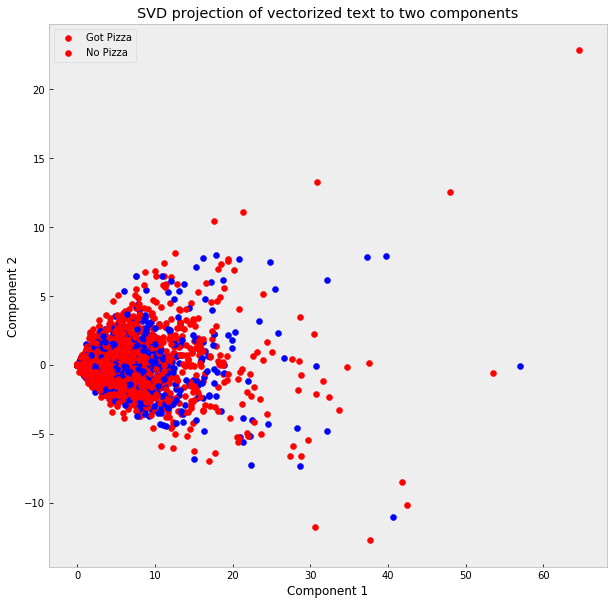

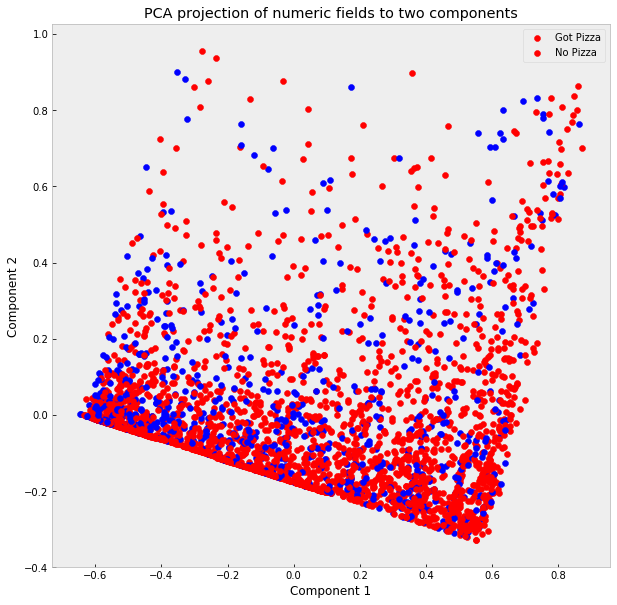

()

In [23]:
def cluster_viz(sparse=True):

    # project data to few dimensions using SVD if sparse, PCA if dense
    if (sparse): svd_train = TruncatedSVD(n_components=2)
    else: svd_train = PCA(n_components=2)
    svd_train_ft = svd_train.fit_transform(x_train)

    # plot the two dimensions
    plt.figure(figsize=(10,10))
    for sample in range(len(y_train)):
        if y_train[sample] == 1:
            color = '#0000ff'
            label = 'Got Pizza'
        else:
            color = '#ff0000'
            label = 'No Pizza'

        plt.scatter(svd_train_ft[sample][0],svd_train_ft[sample][1],c=color,label=label)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(['Got Pizza','No Pizza'])
    if sparse: plt.title('SVD projection of vectorized text to two components')
    else: plt.title('PCA projection of numeric fields to two components')
    plt.grid()
    plt.show()
    
    return()

# Visualize the text data, vectorized then reduced

#Create Sparse matrix of words
count_vect = CountVectorizer()

#Split train and test data
x_train_text, x_test_text, y_train, y_test = train_test_split(
    train_data_master['request_text_edit_aware'], 
    train_labels_master.values.ravel(), test_size=0.2, random_state=0)
x_train = count_vect.fit_transform(x_train_text)
x_test = count_vect.transform(x_test_text)

cluster_viz(sparse=True) # word vectorizer is a sparse matrix, so use SVD

# Visualize the numeric features reduced

#Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
mn_mx_scaler = min_max_scaler.fit_transform(
    train_data_master.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Split train and test data
x_train, x_test, y_train, y_test = train_test_split(
    mn_mx_scaler, 
    train_labels_master.values.ravel(), test_size=0.2, random_state=0)

cluster_viz(sparse=False) # dense matrices, so can use PCA

In [24]:
# Instead of a for-loop, we created separate data sets, using separate variables for each. 

svd_2 = TruncatedSVD(n_components = 2)
vtrain_2 = svd_2.fit(x_train_v)
print(svd_2.explained_variance_ratio_)

svd_3 = TruncatedSVD(n_components = 3)
vtrain_3 = svd_3.fit(x_train_v)
print(svd_3.explained_variance_ratio_)

svd_4 = TruncatedSVD(n_components = 4)
vtrain_4 = svd_4.fit(x_train_v)
print(svd_4.explained_variance_ratio_)

svd_5 = TruncatedSVD(n_components = 5)
vtrain_5 = svd_5.fit(x_train_v)
print(svd_5.explained_variance_ratio_)

svd_6 = TruncatedSVD(n_components = 6)
vtrain_6 = svd_6.fit(x_train_v)
print(svd_6.explained_variance_ratio_)

[ 0.26385154  0.0286785 ]
[ 0.26385154  0.02867851  0.02198617]
[ 0.26385154  0.02867849  0.02198929  0.02079323]
[ 0.26385154  0.02867851  0.02198892  0.02079049  0.01748323]
[ 0.26385154  0.02867849  0.02198842  0.02079198  0.01748568  0.01479941]


In [27]:
raw_score = []
for i in range(1,21):
    kmeans_raw = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans_raw.fit(x_train_v)
    y_hat_kmeans_raw = kmeans_raw.predict(x_train_v)
    centers = kmeans_raw.cluster_centers_
#     print('The KMeans score for the raw data, using',i,'clusters is:',kmeans_raw.score(vtrain[y_hat_kmeans_raw]))
    raw_score.append(kmeans_raw.score(x_train_v[y_hat_kmeans_raw]))
print(raw_score)

svd_2 = TruncatedSVD(n_components = 2)
normalizer = Normalizer(copy=False)
lsa_2 = make_pipeline(svd_2, normalizer)
vtrain_lsa2 = lsa_2.fit_transform(x_train_v)

score_2 = []
for i in range(1,21):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans2.fit(vtrain_lsa2)
    y_hat_kmeans2 = kmeans2.predict(vtrain_lsa2)
    centers = kmeans2.cluster_centers_
#     print('The KMeans score for the truncated, 2 component data, using',i,'clusters is:',
#           kmeans2.score(vtrain_lsa2[y_hat_kmeans]))
    score_2.append(kmeans2.score(vtrain_lsa2[y_hat_kmeans2]))
print(score_2)

svd_3 = TruncatedSVD(n_components = 3)
normalizer = Normalizer(copy=False)
lsa_3 = make_pipeline(svd_3, normalizer)
vtrain_lsa3 = lsa_3.fit_transform(x_train_v)

score_3 = []
for i in range(1,21):
    kmeans3 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans3.fit(vtrain_lsa3)
    y_hat_kmeans3 = kmeans3.predict(vtrain_lsa3)
    centers = kmeans3.cluster_centers_
#     print('The KMeans score for the truncated, 3 component data, using',i,'clusters is:',
#           kmeans3.score(vtrain_lsa3[y_hat_kmeans3]))
    score_3.append(kmeans3.score(vtrain_lsa3[y_hat_kmeans3]))
print(score_3)

svd_4 = TruncatedSVD(n_components = 4)
normalizer = Normalizer(copy=False)
lsa_4 = make_pipeline(svd_4, normalizer)
vtrain_lsa4 = lsa_4.fit_transform(x_train_v)

score_4 = []
for i in range(1,21):
    kmeans4 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans4.fit(vtrain_lsa4)
    y_hat_kmeans4 = kmeans4.predict(vtrain_lsa4)
    centers = kmeans4.cluster_centers_
#     print('The KMeans score for the truncated, 4 component data, using',i,'clusters is:',
#           kmeans4.score(vtrain_lsa4[y_hat_kmeans4]))
    score_4.append(kmeans4.score(vtrain_lsa4[y_hat_kmeans4]))
print(score_4)

svd_5 = TruncatedSVD(n_components = 5)
normalizer = Normalizer(copy=False)
lsa_5 = make_pipeline(svd_5, normalizer)
vtrain_lsa5 = lsa_5.fit_transform(x_train_v)

score_5 = []
for i in range(1,21):
    kmeans5 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans5.fit(vtrain_lsa5)
    y_hat_kmeans5 = kmeans5.predict(vtrain_lsa5)
    centers = kmeans5.cluster_centers_
#     print('The KMeans score for the truncated, 5 component data, using',i,'clusters is:',
#           kmeans5.score(vtrain_lsa5[y_hat_kmeans5]))
    score_5.append(kmeans5.score(vtrain_lsa5[y_hat_kmeans5]))
print(score_5)

svd_6 = TruncatedSVD(n_components = 6)
normalizer = Normalizer(copy=False)
lsa_6 = make_pipeline(svd_6, normalizer)
vtrain_lsa6 = lsa_6.fit_transform(x_train_v)

score_6 = []
for i in range(1,21):
    kmeans6 = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, verbose=False)
    kmeans6.fit(vtrain_lsa6)
    y_hat_kmeans6 = kmeans6.predict(vtrain_lsa6)
    centers = kmeans6.cluster_centers_
#     print('The KMeans score for the truncated, 6 component data, using',i,'clusters is:',
#           kmeans5.score(vtrain_lsa6[y_hat_kmeans6]))
    score_6.append(kmeans6.score(vtrain_lsa6[y_hat_kmeans6]))
print(score_6)

[-114995.70668316251, -94785.40826738653, -208340.4280163003, -118157.34480286209, -346223.3492830459, -222220.82151470173, -220173.69738416857, -239647.84330087976, -273532.0213115599, -192319.3022249429, -307828.4837918481, -255137.37204566307, -239004.4635495402, -120731.73826907473, -175517.0923653365, -227239.29089452024, -185712.57509912373, -166703.13365197036, -85582.21225800115, -265978.3969788435]
[-64.366804926808825, -6.2165813630823772, -84.701649835119326, -27.166933435355752, -38.413012153619754, -67.65314921772125, -12.222586511982026, -11.961942477462362, -6.7211460641124594, -2.641925347612502, -3.7835939175839126, -4.4314109468083345, -2.8140674517783788, -1.6195696357567038, -2.9687251946356388, -3.0404338387829983, -2.0401546814147715, -2.2874321689853074, -4.041361597060229, -3.4637848122476953]
[-915.83367523779646, -179.64520640727898, -312.89649896905922, -332.13888049671175, -197.57955765345298, -221.38925342024214, -145.00013162988739, -116.86952281538507, -1

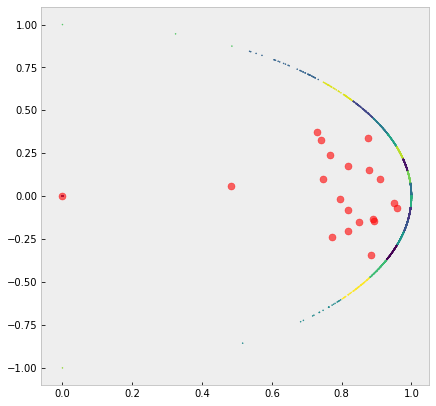

In [33]:
# The plot below wasn't doing much for me
fig2 = plt.figure(0,figsize=(32,32))
ax2 = fig2.add_subplot(4,4,2)

# Draw the plots
ax2.scatter(vtrain_lsa2[:, 0], vtrain_lsa2[:, 1], s=1, c=y_hat_kmeans2)
ax2.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.6)
ax2.grid()

# fig3 = plt.figure(0,figsize=(32,32))
# ax3 = fig3.add_subplot(4,4,2)

# # Draw the plots
# ax3.scatter(vtrain_lsa3[:, 0], vtrain_lsa3[:, 1], s=1, c=y_hat_kmeans3)
# ax3.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.6)
# ax3.grid()

# fig4 = plt.figure(0,figsize=(32,32))
# ax4 = fig4.add_subplot(4,4,2)

# # Draw the plots
# ax4.scatter(vtrain_lsa4[:, 0], vtrain_lsa4[:, 1], s=1, c=y_hat_kmeans4)
# ax4.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.6)
# ax4.grid()

# fig5 = plt.figure(0,figsize=(32,32))
# ax5 = fig5.add_subplot(4,4,2)

# # Draw the plots
# ax5.scatter(vtrain_lsa5[:, 0], vtrain_lsa5[:, 1], s=1, c=y_hat_kmeans5)
# ax5.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.6)
# ax5.grid()

# fig6 = plt.figure(0,figsize=(32,32))
# ax6 = fig6.add_subplot(4,4,2)

# # Draw the plots
# ax6.scatter(vtrain_lsa6[:, 0], vtrain_lsa6[:, 1], s=1, c=y_hat_kmeans6)
# ax6.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.6)
# ax6.grid()

The above figures aren't informative. Most likely, this is due to the structure of the data. 